In [1]:
from aind_brain_segmentation.model.network import Neuratt

checkpoint_path = "/data/best_model_097_2d.ckpt"

segmentation_model = Neuratt()

if checkpoint_path:
    print(f"Loading path from {checkpoint_path}")
    segmentation_model = Neuratt.load_from_checkpoint(checkpoint_path)

segmentation_model.half().eval()
print("Model loaded!")

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
Importing from timm.models.layers is deprecated, please import via timm.layers
monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


Loading path from /data/best_model_097_2d.ckpt
Model loaded!


In [2]:
from aind_brain_segmentation.dataloader import ImageMaskDataset
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

training_path = Path("/scratch/dataset_all_axis_1024_1024_only_smartspim/train")
validation_path = Path("/scratch/dataset_all_axis_1024_1024_only_smartspim/test")
batch_size = 2
num_workers = 8

train_dataset = ImageMaskDataset(
    training_path.joinpath('images'),
    training_path.joinpath('masks'),
)
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)
print(f"Train len data loader: {len(train_dataloader)}")

val_dataset = ImageMaskDataset(
    validation_path.joinpath('images'),
    validation_path.joinpath('masks'),
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
)
print(f"Val len data loader: {len(val_dataloader)}")

Train len data loader: 8259
Val len data loader: 2403


In [3]:
import torch
import numpy as np
from tqdm import tqdm

def convert_feature_list_to_numpy(feats_):
    reference_shape = feats_[0].shape
    feats_ = [arr for arr in feats_ if arr.shape == reference_shape]
    feat_vects_np = np.stack(feats_)
    new_shape = (np.prod(feat_vects_np.shape[:-3]), ) + (-1,)
    feat_vects_np = feat_vects_np.reshape(new_shape)
    return feat_vects_np

def compute_vector_features(
    curr_dataloader,
    seg_model,
    prob_threshold = 0.7,
    device = torch.device(0)
):
    feat_vects = []
    print(f"data loader: {len(curr_dataloader)}")
    
    for i, (image, mask) in enumerate(tqdm(curr_dataloader, desc="Processing")):
        image = image.float().half().to(device)
        hidden_states = seg_model.model.swinViT(image)
        feat_vects.append(
            hidden_states[-1].detach().cpu().numpy()
        )
        # pred_mask, prob_mask = segmentation_model.predict(
        #     image, threshold=prob_threshold
        # )
        # print(pred_mask.shape, prob_mask.shape)

    feat_vects = convert_feature_list_to_numpy(feat_vects)
    
    print(f"Done! Feature vector: {feat_vects.shape}")
    return feat_vects


In [4]:
print(f"Getting training features!")
train_features = compute_vector_features(
    curr_dataloader=train_dataloader,
    seg_model=segmentation_model,
    prob_threshold = 0.7,
    device = torch.device(0)
)

Getting training features!
data loader: 8259


Processing: 100%|██████████| 8259/8259 [13:27<00:00, 10.22it/s]


Done! Feature vector: (16516, 196608)


In [5]:
np.save("/results/training_features.npy", train_features)

In [8]:
import zarr

def save_features_as_zarr(feats_np, output_path):
    chunk_size = (128, feats_np.shape[-1])
    
    zarr_file = zarr.open(
        output_path,
        mode='w',
        shape=feats_np.shape,
        chunks=chunk_size,
        dtype=feats_np.dtype
    )
    zarr_file[:] = feats_np
    
    print(f"Zarr written to: {output_path}")

save_features_as_zarr(
    train_features,
    output_path="/results/training_features.zarr"
)

Zarr written to: /results/training_features.zarr


In [11]:
print(f"Getting validation features!")
val_features = compute_vector_features(
    curr_dataloader=val_dataloader,
    seg_model=segmentation_model,
    prob_threshold = 0.7,
    device = torch.device(0)
)

Getting validation features!
data loader: 2403


Processing: 100%|██████████| 2403/2403 [04:00<00:00,  9.98it/s]


Done! Feature vector: (4806, 196608)


In [12]:
np.save("/results/validation_features.npy", val_features)
save_features_as_zarr(
    val_features,
    output_path="/results/validation_features.zarr"
)

Zarr written to: /results/validation_features.zarr


# Creating clusters for training and validation to check OODs

In [1]:
import dask.array as da

training_features = da.from_zarr("/results/training_features.zarr")
validation_features = da.from_zarr("/results/validation_features.zarr")

training_features

dask.array<from-zarr, shape=(16516, 196608), dtype=float16, chunksize=(128, 196608), chunktype=numpy.ndarray>

In [2]:
validation_features

dask.array<from-zarr, shape=(4806, 196608), dtype=float16, chunksize=(128, 196608), chunktype=numpy.ndarray>

# Getting feature data

In [3]:
from scipy.stats import gaussian_kde
import numpy as np

start_pos = 1000
n_samples = 2000

training_features_in_mem = training_features.compute()
training_features_in_mem = np.array([
    arr for arr in training_features_in_mem if not np.any(np.isnan(arr) | np.isinf(arr))
],
    dtype=training_features_in_mem.dtype
)

validation_features_in_mem = validation_features.compute()
validation_features_in_mem = np.array([
    arr for arr in validation_features_in_mem if not np.any(np.isnan(arr) | np.isinf(arr))
],
    dtype=validation_features_in_mem.dtype
)

print(training_features_in_mem.shape, validation_features_in_mem.shape)
print(np.isnan(training_features_in_mem).any())
print(np.isnan(validation_features_in_mem).any())

(16502, 196608) (4804, 196608)
False
False


# Computing PCA leaving the first 100 components

In [4]:
from sklearn.decomposition import PCA

sample_from_training = training_features_in_mem[start_pos:start_pos+n_samples]
sample_from_validation = validation_features_in_mem[start_pos:start_pos+n_samples]

print(sample_from_training.shape, sample_from_validation.shape)

del validation_features_in_mem
del training_features_in_mem

# Apply PCA to reduce dimensions to 1D
n_features = 100

pca = PCA(n_components=n_features)
train_pca = pca.fit_transform(sample_from_training)
val_pca = pca.transform(sample_from_validation)
print(train_pca.shape, val_pca.shape)

(2000, 196608) (2000, 196608)
(2000, 100) (2000, 100)


## Getting a kernel density estimation to estimate the probability density function

Useful to check the data distribution of both sets of data.

In [5]:
kde_training = gaussian_kde(train_pca.flatten().T, bw_method=None, weights=None)
kde_validation = gaussian_kde(val_pca.flatten().T, bw_method=None, weights=None)

In [6]:
# Checking I'm using a single dimension as feature for the distribution!!
kde_training.dataset.shape

(1, 200000)

In [88]:
# log_likelihood = np.mean(kde_training.logpdf(val_pca.T))
# print("Log likelihood ", log_likelihood)

Log likelihood  -880.870393866117


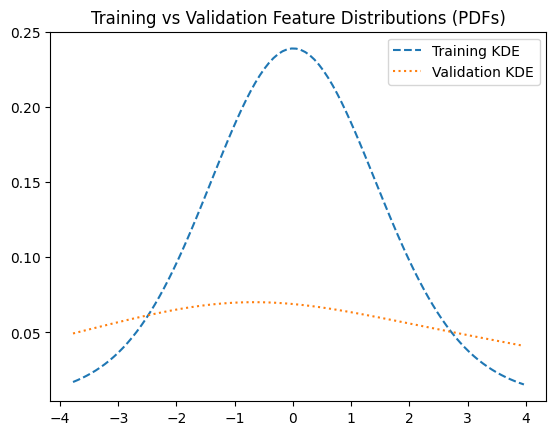

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

min_val = np.min([np.min(sample_from_training), np.min(sample_from_validation)])
max_val = np.max([np.max(sample_from_training), np.max(sample_from_validation)])

x_grid = np.linspace(min_val, max_val, 100)

pdf_training = kde_training(x_grid)
pdf_validation = kde_validation(x_grid)

plt.plot(x_grid, pdf_training, label="Training KDE", linestyle="--")
plt.plot(x_grid, pdf_validation, label="Validation KDE", linestyle=":")
plt.legend()
plt.title("Training vs Validation Feature Distributions (PDFs)")
plt.show()

In [11]:
import seaborn as sns
from sklearn.manifold import TSNE
from scipy import stats

def analyze_feature_distributions(train_features, val_features, n_features=None):
    """
    Analyze the distributions of individual features/components between train and validation sets.
    Works with 1D PCA components by handling them as a single feature.
    
    Parameters:
    -----------
    train_features : numpy.ndarray
        Training features, can be 1D array of shape (n_samples,)
    val_features : numpy.ndarray
        Validation features, can be 1D array of shape (n_samples,)
    n_features : int, optional
        Number of features to analyze. If None, analyze all features.
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure object with the plots
    """
    
    # Reshape 1D arrays to 2D if needed
    if train_features.ndim == 1:
        train_features = train_features.reshape(-1, 1)
    if val_features.ndim == 1:
        val_features = val_features.reshape(-1, 1)
    
    # Total number of features
    total_features = train_features.shape[1]
    
    # If n_features is not specified, analyze all features (up to a reasonable maximum)
    if n_features is None:
        n_features = min(total_features, 20)  # Limit to 20 to avoid too many plots
    else:
        n_features = min(n_features, total_features)  # Cannot analyze more features than we have
    
    # Calculate the Jensen-Shannon distance between train and val for each feature
    js_distances = []
    ks_statistics = []
    
    for i in range(total_features):
        # Create histograms with same bins for both datasets
        bins = np.linspace(
            min(train_features[:, i].min(), val_features[:, i].min()),
            max(train_features[:, i].max(), val_features[:, i].max()),
            50
        )
        train_hist, _ = np.histogram(train_features[:, i], bins=bins, density=True)
        val_hist, _ = np.histogram(val_features[:, i], bins=bins, density=True)
        
        # Add small constant to avoid zero probabilities
        train_hist = train_hist + 1e-10
        val_hist = val_hist + 1e-10
        
        # Normalize
        train_hist = train_hist / train_hist.sum()
        val_hist = val_hist / val_hist.sum()
        
        # Calculate JS distance
        m = 0.5 * (train_hist + val_hist)
        js_dist = 0.5 * (stats.entropy(train_hist, m) + stats.entropy(val_hist, m))
        js_distances.append(js_dist)
        
        # Calculate KS statistic
        ks_stat, _ = stats.ks_2samp(train_features[:, i], val_features[:, i])
        ks_statistics.append(ks_stat)
    
    # For single feature case, force analysis of that feature
    if total_features == 1:
        top_features = [0]
    else:
        # Select features with highest JS distances or KS statistics
        # We'll use KS statistics as they often work better for detecting distribution differences
        top_features = np.argsort(ks_statistics)[-n_features:]
    
    # Create multi-plot for selected features
    n_cols = min(2, n_features)
    n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    
    # Make axes iterable even for single subplot
    if n_features == 1:
        axes = np.array([axes])
    
    # Flatten the axes array for easier indexing
    if n_rows > 1 and n_cols > 1:
        axes = axes.flatten()
    
    for i, feature_idx in enumerate(top_features):
        if i < len(axes):  # Ensure we don't go out of bounds
            ax = axes[i]
            
            # Determine the most appropriate visualization based on data size
            if len(train_features) > 10000 or len(val_features) > 10000:
                # For large datasets, KDE or histogram with fewer bins is more efficient
                sns.kdeplot(train_features[:, feature_idx], ax=ax, color='blue', label='Train')
                sns.kdeplot(val_features[:, feature_idx], ax=ax, color='red', label='Validation')
            else:
                # For smaller datasets, we can use histograms with KDE
                sns.histplot(train_features[:, feature_idx], kde=True, 
                         alpha=0.5, color='blue', label='Train', ax=ax, stat='density')
                sns.histplot(val_features[:, feature_idx], kde=True, 
                         alpha=0.5, color='red', label='Validation', ax=ax, stat='density')
            
            # Add statistics
            train_mean = train_features[:, feature_idx].mean()
            val_mean = val_features[:, feature_idx].mean()
            train_std = train_features[:, feature_idx].std()
            val_std = val_features[:, feature_idx].std()
            
            ks_stat, p_value = stats.ks_2samp(
                train_features[:, feature_idx], 
                val_features[:, feature_idx]
            )
            
            feature_name = f"PCA Component {feature_idx}" if total_features > 1 else "PCA Component"
            ax.set_title(f'{feature_name} (KS={ks_stat:.4f}, p={p_value:.4g})')
            
            # Add text with statistics
            ax.text(0.02, 0.95, 
                    f'Train: μ={train_mean:.2f}, σ={train_std:.2f}\n'
                    f'Val: μ={val_mean:.2f}, σ={val_std:.2f}\n'
                    f'KS p-value: {p_value:.4g}', 
                    transform=ax.transAxes, 
                    bbox=dict(facecolor='white', alpha=0.8),
                    verticalalignment='top')
            ax.legend()
    
    # Remove any unused subplots
    for i in range(n_features, len(axes)):
        fig.delaxes(axes[i])
    
    plt.tight_layout()
    return fig
    
# analyze_feature_distributions(train_pca, val_pca, n_features=4)

In [12]:
def tsne_visualization(train_features, val_features, perplexity=30):
    """
    Create t-SNE visualization to compare train and validation distributions.
    Works with 1D PCA components by reshaping them appropriately.
    
    Parameters:
    -----------
    train_features : numpy.ndarray
        Training features, can be 1D array of shape (n_samples,)
    val_features : numpy.ndarray
        Validation features, can be 1D array of shape (n_samples,)
    perplexity : int, optional
        Perplexity parameter for t-SNE (default: 30)
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure object with the t-SNE plot
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.manifold import TSNE
    
    # Reshape 1D arrays to 2D if needed
    if train_features.ndim == 1:
        train_features = train_features.reshape(-1, 1)
    if val_features.ndim == 1:
        val_features = val_features.reshape(-1, 1)
    
    # Combine data for t-SNE
    combined = np.vstack([train_features, val_features])
    
    # For very large datasets, subsample to a reasonable size for t-SNE
    max_samples = 10000  # Adjust based on your computational resources
    if combined.shape[0] > max_samples:
        # Subsample evenly from both datasets
        train_samples = min(len(train_features), max_samples // 2)
        val_samples = min(len(val_features), max_samples // 2)
        
        train_indices = np.random.choice(len(train_features), train_samples, replace=False)
        val_indices = np.random.choice(len(val_features), val_samples, replace=False)
        
        train_subset = train_features[train_indices]
        val_subset = val_features[val_indices]
        combined = np.vstack([train_subset, val_subset])
        
        print(f"Subsampled {train_samples} training samples and {val_samples} validation samples for t-SNE visualization")
    
    # Apply t-SNE
    print("Computing t-SNE projection...")
    tsne = TSNE(n_components=2, perplexity=min(perplexity, combined.shape[0] // 5), 
                random_state=42, n_jobs=-1)
    combined_tsne = tsne.fit_transform(combined)
    
    # Split back into train and validation
    if combined.shape[0] == len(train_features) + len(val_features):
        train_tsne = combined_tsne[:len(train_features)]
        val_tsne = combined_tsne[len(train_features):]
    else:
        # If we subsampled
        train_tsne = combined_tsne[:train_samples]
        val_tsne = combined_tsne[train_samples:]
    
    # Create plot
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    # 1. Scatter plot
    ax = axes[0]
    ax.scatter(train_tsne[:, 0], train_tsne[:, 1], alpha=0.5, 
               label='Train', color='blue', s=10)
    ax.scatter(val_tsne[:, 0], val_tsne[:, 1], alpha=0.5, 
               label='Validation', color='red', s=10)
    
    ax.set_title('t-SNE Visualization of Distribution')
    ax.legend()
    
    # 2. Density visualization using hexbins for better visualization with large datasets
    ax = axes[1]
    ax.hexbin(train_tsne[:, 0], train_tsne[:, 1], gridsize=50, cmap='Blues', alpha=0.7, label='Train')
    h_val = ax.hexbin(val_tsne[:, 0], val_tsne[:, 1], gridsize=50, cmap='Reds', alpha=0.7, label='Validation')
    
    ax.set_title('Density Visualization (Hexbin)')
    
    # Create proxy artists for legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', alpha=0.7, label='Train'),
        Patch(facecolor='red', alpha=0.7, label='Validation')
    ]
    ax.legend(handles=legend_elements)
    
    plt.tight_layout()
    return fig

# tsne_visualization(train_pca, val_pca, perplexity=30)

In [13]:
def analyze_single_component_distribution(train_component, val_component, title="PCA Component Distribution"):
    """
    Detailed analysis of a single component distribution.
    Specifically designed for 1D arrays from PCA.
    
    Parameters:
    -----------
    train_component : numpy.ndarray
        1D array of training component values
    val_component : numpy.ndarray
        1D array of validation component values
    title : str, optional
        Plot title
        
    Returns:
    --------
    matplotlib.figure.Figure
        Figure with detailed distribution analysis
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy import stats
    
    # Create figure with multiple plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Histogram and KDE comparison
    ax = axes[0, 0]
    sns.histplot(train_component, kde=True, stat='density', 
                alpha=0.5, color='blue', label='Train', ax=ax)
    sns.histplot(val_component, kde=True, stat='density', 
                alpha=0.5, color='red', label='Validation', ax=ax)
    
    # Calculate basic statistics
    train_mean = np.mean(train_component)
    val_mean = np.mean(val_component)
    train_std = np.std(train_component)
    val_std = np.std(val_component)
    
    # Calculate KS test
    ks_stat, p_value = stats.ks_2samp(train_component, val_component)
    
    ax.set_title(f'Distribution Comparison (KS={ks_stat:.4f}, p={p_value:.4g})')
    ax.axvline(train_mean, color='blue', linestyle='--', alpha=0.8, label=f'Train Mean={train_mean:.2f}')
    ax.axvline(val_mean, color='red', linestyle='--', alpha=0.8, label=f'Val Mean={val_mean:.2f}')
    ax.legend()
    
    # 2. QQ plot
    ax = axes[0, 1]
    # Sort the data
    train_sorted = np.sort(train_component)
    val_sorted = np.sort(val_component)
    
    # If datasets have different sizes, interpolate to match
    if len(train_sorted) != len(val_sorted):
        if len(train_sorted) > len(val_sorted):
            # Interpolate validation to match training size
            indices = np.linspace(0, len(val_sorted)-1, len(train_sorted))
            val_interp = np.interp(indices, np.arange(len(val_sorted)), val_sorted)
            x = train_sorted
            y = val_interp
        else:
            # Interpolate training to match validation size
            indices = np.linspace(0, len(train_sorted)-1, len(val_sorted))
            train_interp = np.interp(indices, np.arange(len(train_sorted)), train_sorted)
            x = train_interp
            y = val_sorted
    else:
        x = train_sorted
        y = val_sorted
    
    # Create QQ plot
    ax.scatter(x, y, alpha=0.5)
    
    # Add reference line (y=x)
    min_val = min(x.min(), y.min())
    max_val = max(x.max(), y.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    ax.set_xlabel('Training Quantiles')
    ax.set_ylabel('Validation Quantiles')
    ax.set_title('QQ Plot (points along line = similar distributions)')
    
    # Add r^2 value to measure linearity
    slope, intercept, r_value, _, _ = stats.linregress(x, y)
    ax.text(0.05, 0.95, f'R² = {r_value**2:.4f}\nSlope = {slope:.4f}', 
            transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.8))
    
    # 3. Boxplot comparison
    ax = axes[1, 0]
    box_data = [train_component, val_component]
    ax.boxplot(box_data, labels=['Train', 'Validation'])
    ax.set_title('Boxplot Comparison')
    
    # Add statistical test results
    # t-test
    t_stat, t_p = stats.ttest_ind(train_component, val_component, equal_var=False)
    # Mann-Whitney U test
    u_stat, u_p = stats.mannwhitneyu(train_component, val_component)
    
    ax.text(0.05, 0.95, 
            f'Statistics:\n'
            f't-test: p={t_p:.4g}\n'
            f'Mann-Whitney U: p={u_p:.4g}', 
            transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.8),
            verticalalignment='top')
    
    # 4. ECDF comparison
    ax = axes[1, 1]
    
    # Calculate ECDF for both datasets
    def ecdf(data):
        x = np.sort(data)
        y = np.arange(1, len(data) + 1) / len(data)
        return x, y
    
    x_train, y_train = ecdf(train_component)
    x_val, y_val = ecdf(val_component)
    
    ax.plot(x_train, y_train, 'b-', label='Train')
    ax.plot(x_val, y_val, 'r-', label='Validation')
    ax.set_title('Empirical Cumulative Distribution')
    ax.set_xlabel('Value')
    ax.set_ylabel('Cumulative Probability')
    ax.legend()
    
    # Add KS statistic as the maximum vertical distance
    ax.text(0.05, 0.95, 
            f'KS statistic: {ks_stat:.4f}\n'
            f'p-value: {p_value:.4g}',
            transform=ax.transAxes, 
            bbox=dict(facecolor='white', alpha=0.8),
            verticalalignment='top')
    
    # Overall title
    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust for suptitle
    
    return fig

# analyze_single_component_distribution(train_pca[:, 3], val_pca[:, 3], title="PCA Component Distribution")

Computing t-SNE projection...


/tmp/ipykernel_8088/1284361001.py:93: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(box_data, labels=['Train', 'Validation'])


{'feature_distributions': <Figure size 1500x5000 with 20 Axes>,
 'tsne_visualization': <Figure size 2000x1000 with 2 Axes>,
 'component_analysis': <Figure size 1500x1200 with 4 Axes>,
 'summary': <Figure size 1200x600 with 1 Axes>}

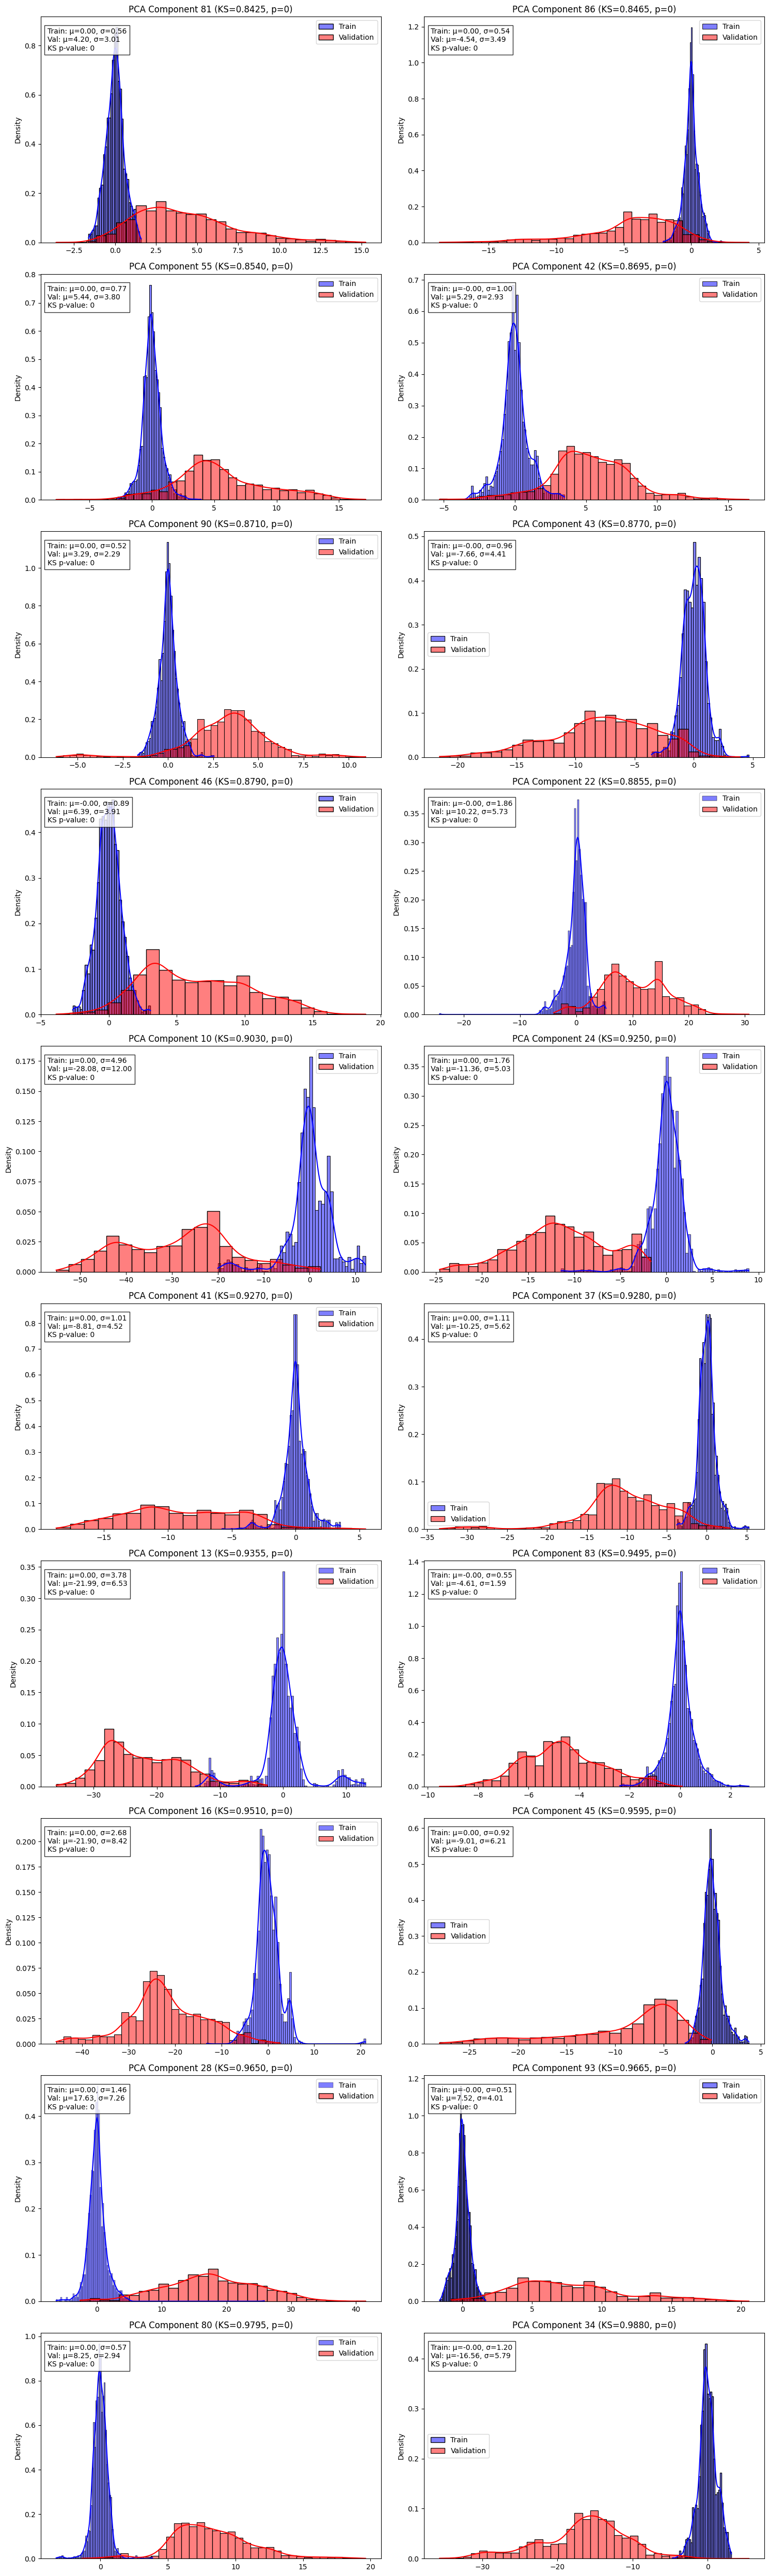

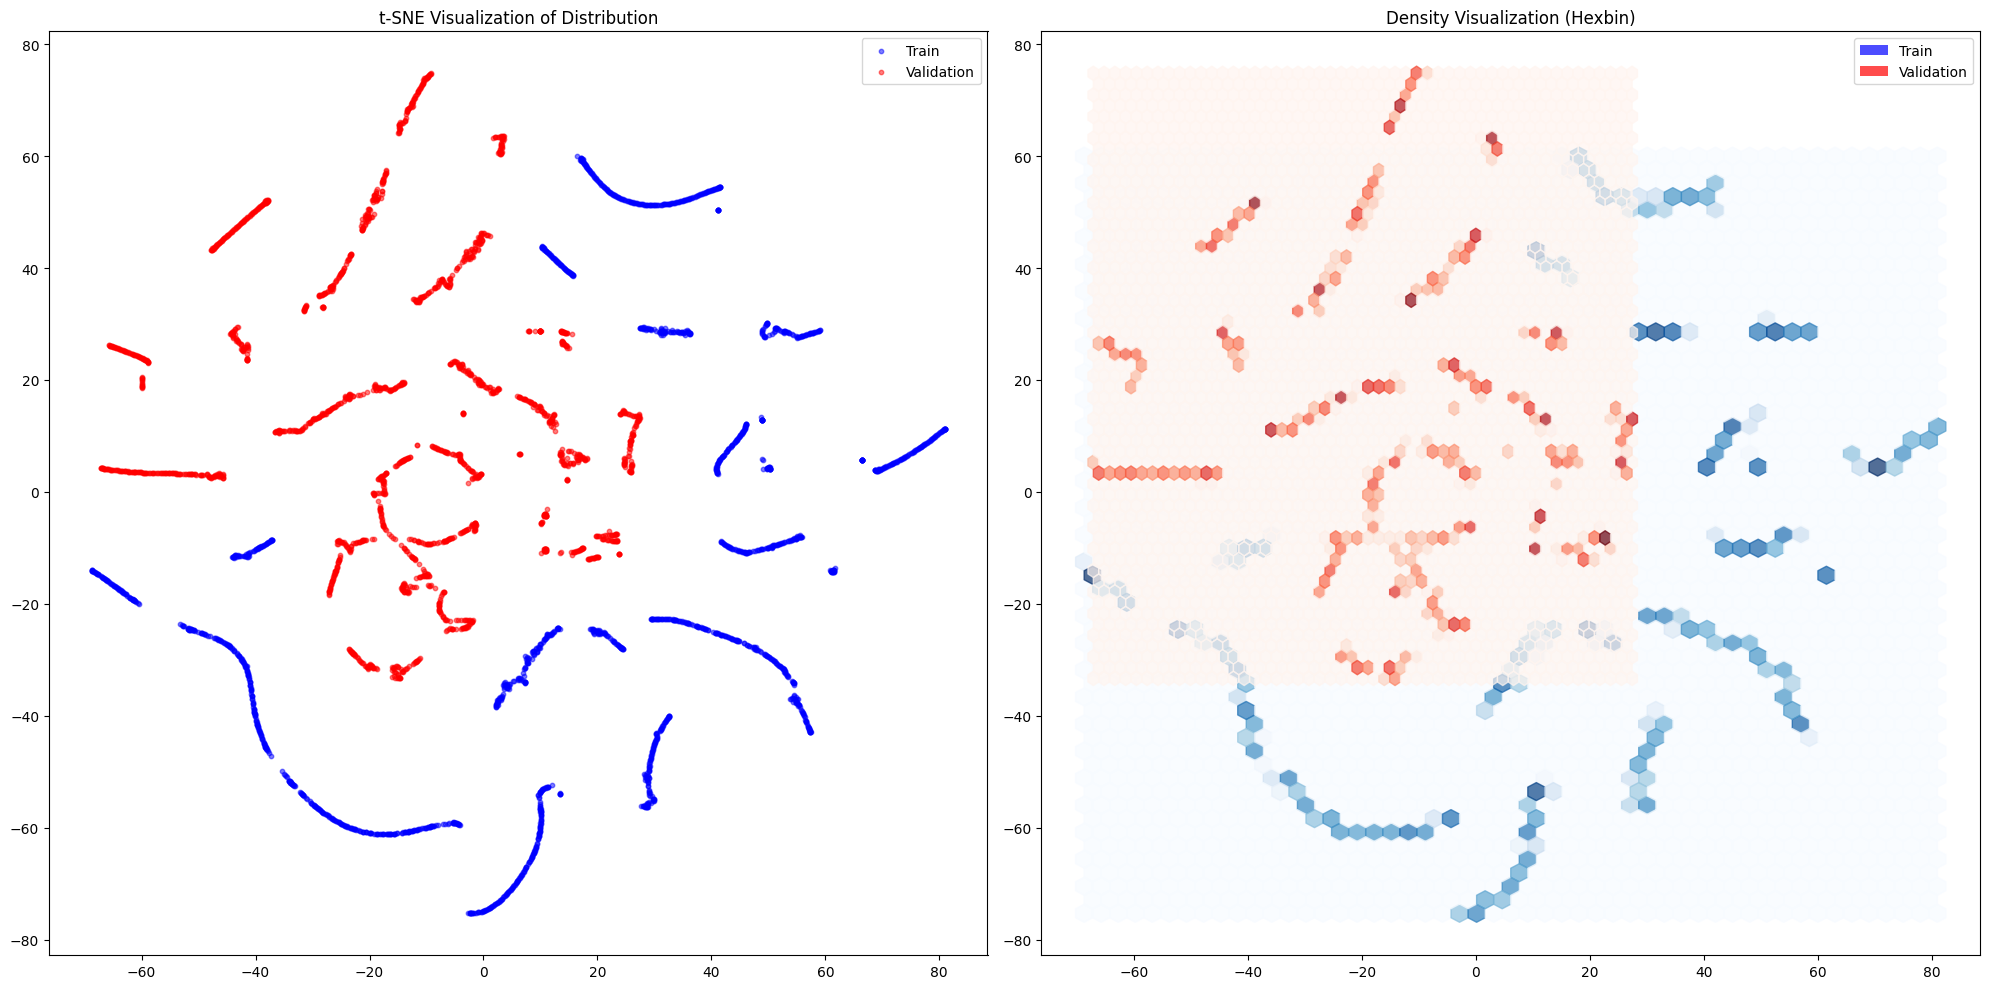

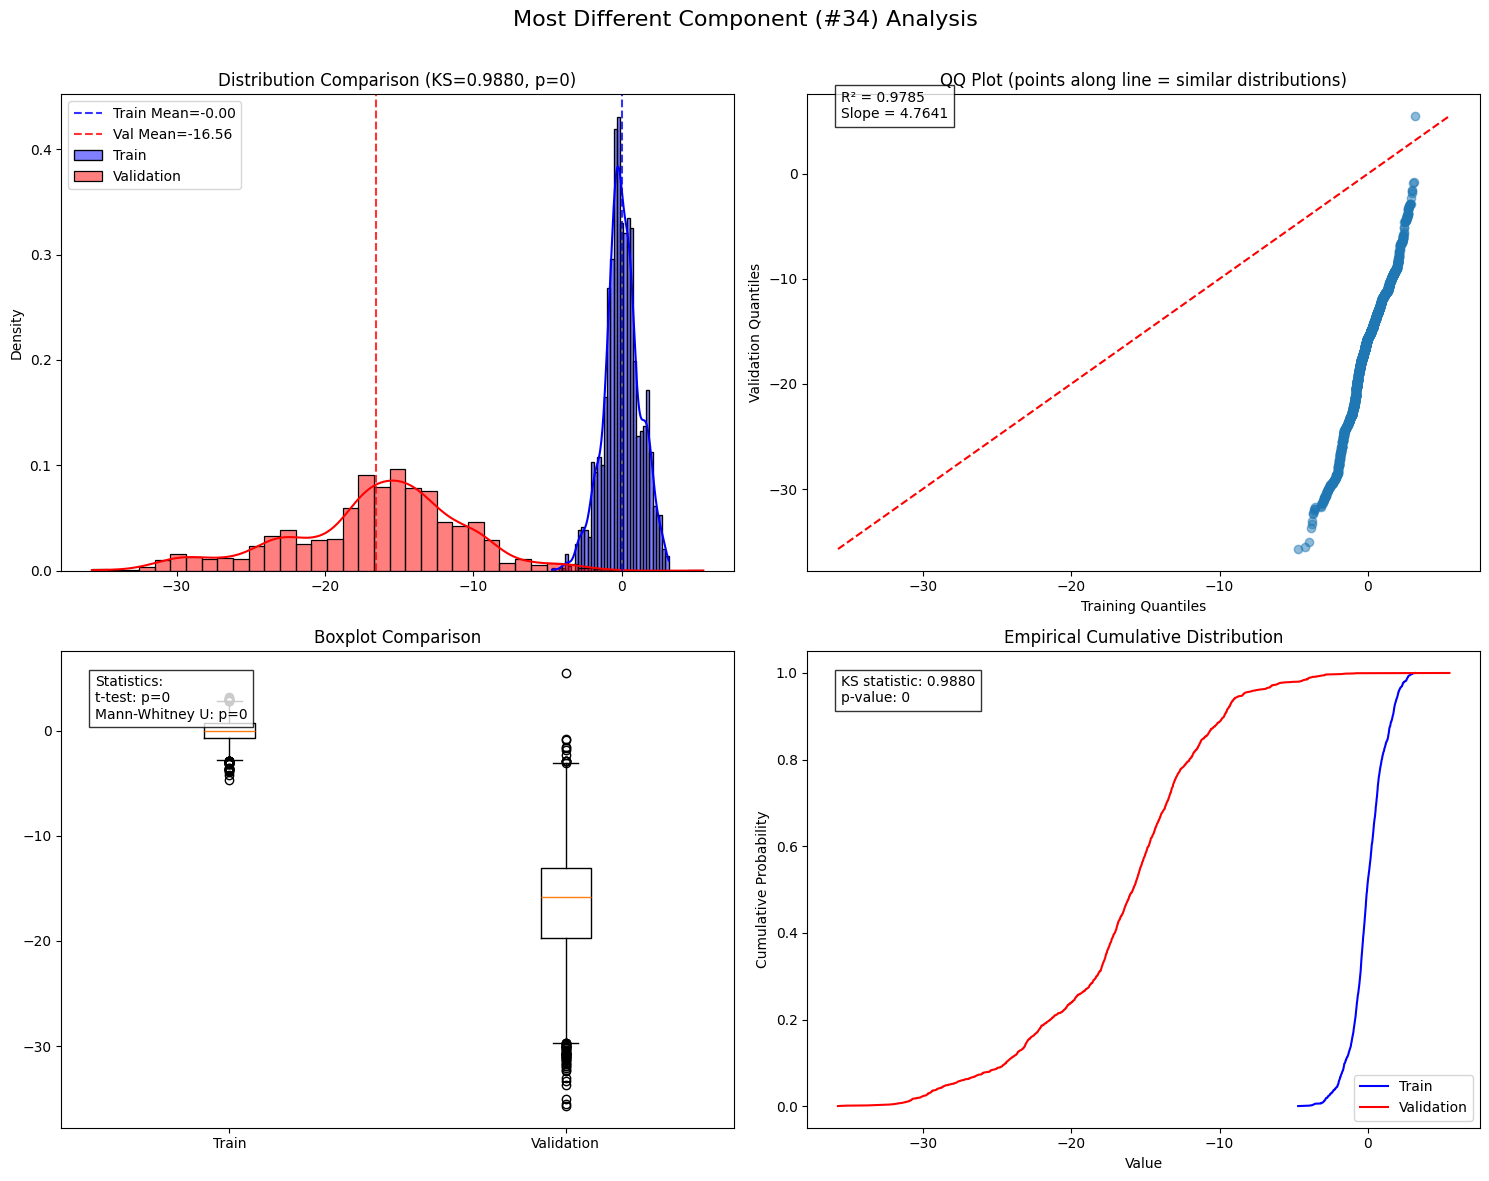

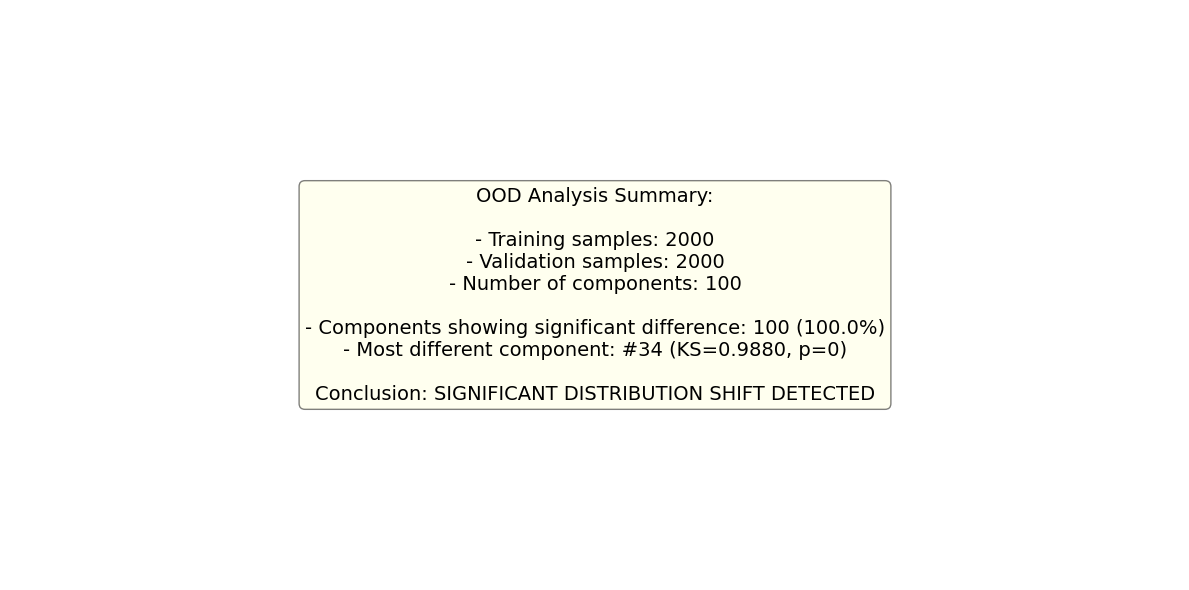

In [16]:
def visualize_ood_analysis_for_pca(train_pca, val_pca, sample_size=5000):
    """
    Comprehensive visualization function for analyzing OOD on PCA components.
    Works with 1D arrays by reshaping them appropriately.
    
    Parameters:
    -----------
    train_pca : numpy.ndarray
        Training PCA components, can be 1D array of shape (n_samples,)
    val_pca : numpy.ndarray
        Validation PCA components, can be 1D array of shape (n_samples,)
    sample_size : int, optional
        Number of samples to use for t-SNE (default: 5000)
        
    Returns:
    --------
    dict
        Dictionary containing figure objects
    """
    
    # Reshape 1D arrays to 2D if needed
    if train_pca.ndim == 1:
        train_pca = train_pca.reshape(-1, 1)
    if val_pca.ndim == 1:
        val_pca = val_pca.reshape(-1, 1)
    
    # Get feature distribution analysis
    feature_fig = analyze_feature_distributions(train_pca, val_pca)
    
    # For t-SNE visualization, subsample if needed
    if len(train_pca) + len(val_pca) > sample_size * 2:
        train_indices = np.random.choice(len(train_pca), min(sample_size, len(train_pca)), replace=False)
        val_indices = np.random.choice(len(val_pca), min(sample_size, len(val_pca)), replace=False)
        train_sample = train_pca[train_indices]
        val_sample = val_pca[val_indices]
        tsne_fig = tsne_visualization(train_sample, val_sample)
    else:
        tsne_fig = tsne_visualization(train_pca, val_pca)
    
    # For single component, provide detailed analysis
    if train_pca.shape[1] == 1:
        component_fig = analyze_single_component_distribution(
            train_pca.flatten(), val_pca.flatten(), 
            title="PCA Component Detailed Analysis"
        )
    else:
        # Calculate KS statistics for all components
        ks_stats = []
        p_values = []
        for i in range(train_pca.shape[1]):
            ks_stat, p_value = stats.ks_2samp(train_pca[:, i], val_pca[:, i])
            ks_stats.append(ks_stat)
            p_values.append(p_value)
        
        # Find the component with the most significant difference
        most_diff_idx = np.argmax(ks_stats)
        
        component_fig = analyze_single_component_distribution(
            train_pca[:, most_diff_idx], val_pca[:, most_diff_idx], 
            title=f"Most Different Component (#{most_diff_idx}) Analysis"
        )
    
    # Summary statistics
    n_components = train_pca.shape[1]
    
    # Calculate percentage of components that show significant difference
    if n_components > 1:
        sig_diff_count = sum(1 for p in p_values if p < 0.05)
        sig_diff_percent = (sig_diff_count / n_components) * 100
    else:
        ks_stat, p_value = stats.ks_2samp(train_pca.flatten(), val_pca.flatten())
        sig_diff_count = 1 if p_value < 0.05 else 0
        sig_diff_percent = 100 if p_value < 0.05 else 0
    
    # Create summary figure
    summary_fig = plt.figure(figsize=(12, 6))
    ax = summary_fig.add_subplot(111)
    ax.axis('off')
    
    summary_text = f"OOD Analysis Summary:\n\n"
    summary_text += f"- Training samples: {len(train_pca)}\n"
    summary_text += f"- Validation samples: {len(val_pca)}\n"
    summary_text += f"- Number of components: {n_components}\n\n"
    
    if n_components > 1:
        summary_text += f"- Components showing significant difference: {sig_diff_count} ({sig_diff_percent:.1f}%)\n"
        summary_text += f"- Most different component: #{most_diff_idx} (KS={ks_stats[most_diff_idx]:.4f}, p={p_values[most_diff_idx]:.4g})\n\n"
    else:
        summary_text += f"- Single component KS test: {ks_stat:.4f} (p={p_value:.4g})\n\n"
    
    # Overall conclusion
    if sig_diff_percent > 50:
        conclusion = "SIGNIFICANT DISTRIBUTION SHIFT DETECTED"
    elif sig_diff_percent > 20:
        conclusion = "MODERATE DISTRIBUTION SHIFT DETECTED"
    else:
        conclusion = "MINOR OR NO DISTRIBUTION SHIFT DETECTED"
    
    summary_text += f"Conclusion: {conclusion}"
    
    ax.text(0.5, 0.5, summary_text, ha='center', va='center', fontsize=14,
            bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.5))
    
    plt.tight_layout()
    
    return {
        'feature_distributions': feature_fig,
        'tsne_visualization': tsne_fig,
        'component_analysis': component_fig,
        'summary': summary_fig
    }

visualize_ood_analysis_for_pca(train_pca, val_pca, sample_size=val_pca.shape[0])

# Computing distance based OODs

In [8]:
from frouros.detectors.data_drift import MMD, JS, CVMTest, EMD, KL, HellingerDistance
from functools import partial
from frouros.utils.kernels import rbf_kernel
from scipy.spatial.distance import pdist
from frouros.callbacks import PermutationTestDistanceBased

def get_set_statistics(features):
    mean = np.mean(features, axis=0)
    std = np.std(features, axis=0)

    return {
        'mean': mean,
        'std': std,
    }

def compute_distance_based_bins(x_features, x_i_feats, fuoros_obj, bins, alpha=0.01, num_permutations=3):

    drift_detected = False
    
    detector = fuoros_obj(
        bins,
        callbacks=[
            PermutationTestDistanceBased(
                num_permutations=num_permutations,
                random_state=42,
                num_jobs=-1,
                method="exact",
                name="permutation_test",
                verbose=True,
            ),
        ],
    )
    detector.fit(X=x_features)
    dt, callbacks_log = detector.compare(X=x_i_feats)
    p_value = callbacks_log['permutation_test']['p_value']
    if p_value <= alpha:
        drift_detected = True

    return {
        'dt': dt,
        'callback': callbacks_log,
        'drift_detected': drift_detected
    }

def compute_maximum_mean_discrepancy(x_features, x_i_feats, sigma, alpha=0.01, num_permutations=3):

    drift_detected = False
    
    detector = MMD(
        kernel=partial(
            rbf_kernel,
            sigma=sigma,
        ),
        callbacks=[
            PermutationTestDistanceBased(
                num_permutations=num_permutations,
                random_state=42,
                num_jobs=-1,
                method="exact",
                name="permutation_test",
                verbose=True,
            ),
        ],
    )
    detector.fit(X=x_features)
    mmd, callbacks_log = detector.compare(X=x_i_feats)
    p_value = callbacks_log['permutation_test']['p_value']
    if p_value <= alpha:
        drift_detected = True

    return {
        'dt': mmd,
        'callback': callbacks_log,
        'drift_detected': drift_detected
    }

def compute_earths_movers_distance(x_features, x_i_feats, sigma, alpha=0.01, num_permutations=3):

    drift_detected = False
    
    detector = EMD(
        callbacks=[
            PermutationTestDistanceBased(
                num_permutations=num_permutations,
                random_state=42,
                num_jobs=-1,
                method="exact",
                name="permutation_test",
                verbose=True,
            ),
        ],
    )
    detector.fit(X=x_features)
    emd_r, callbacks_log = detector.compare(X=x_i_feats)
    p_value = callbacks_log['permutation_test']['p_value']
    if p_value <= alpha:
        drift_detected = True

    return {
        'dt': emd_r,
        'callback': callbacks_log,
        'drift_detected': drift_detected
    }

train_pca_flat = train_pca.flatten().astype(np.float16)
val_pca_flat = val_pca.flatten().astype(np.float16)

# the recommended value for sigma when using an RBF kernel
# is the median distance between points in the aggregate space
# this means, x_feats and x_i_feats
sigma = (
    np.median(
        pdist(
            X=np.vstack((train_pca_flat, val_pca_flat)),
            metric="euclidean",
        )
    )
    / 2
)

print("Using sigma: ", sigma)

distance_tests = {
    'JS': {
        'function': compute_distance_based_bins,
        'params': {
            # 'x_features': train_pca_flat,
            # 'x_i_feats': val_pca_flat,
            'fuoros_obj': JS,
            'bins': 30,
            'alpha': 0.01,
            'num_permutations': 3,
        }
    },
    'EMD': {
        'function': compute_earths_movers_distance,
        'params': {
            # 'x_features': train_pca_flat,
            # 'x_i_feats': val_pca_flat,
            'sigma': sigma,
            'alpha': 0.01,
            'num_permutations': 3,
        }
    },
    'KL': {
        'function': compute_distance_based_bins,
        'params': {
            # 'x_features': train_pca_flat,
            # 'x_i_feats': val_pca_flat,
            'fuoros_obj': KL,
            'bins': 30,
            'alpha': 0.01,
            'num_permutations': 3,
        }
    },
    'MMD': {
        'function': compute_maximum_mean_discrepancy,
        'params': {
            # 'x_features': train_pca_flat,
            # 'x_i_feats': val_pca_flat,
            'sigma': sigma,
            'alpha': 0.01,
            'num_permutations': 3,
        }
    },
}

chunks = {}
step = 1000

for pos in range(0, val_pca_flat.shape[0], step):
    print(f"Running {pos}:{pos+step}")
    curr_train_pca_flat = train_pca_flat[pos: pos+step]
    curr_val_pca_flat = val_pca_flat[pos: pos+step]

    results_list = []
    metric_names = []
    for name, obj in distance_tests.items():
        print(f"Running {name}")
        results = obj['function'](
            x_features=curr_train_pca_flat,
            x_i_feats=curr_val_pca_flat,
            **obj['params']
        )
        # print(f"{name} results: {results}")
    
        if not np.isinf(results['dt'].distance):
            # Convert your format to the expected format
            formatted_results = {
                'dt': results['dt'].distance,
                'callback': results['callback'],
                'drift_detected': results['drift_detected']
            }
            
            # # Create visualization
            # fig = visualize_drift_detection(formatted_results, title="Distribution Drift Analysis")
            # plt.show()
            results_list.append(formatted_results)
            metric_names.append(name)

    chunks[f"{pos}:{pos+step}"] = {
        'results': results_list,
        'names': metric_names
    }

print(chunks)


Using sigma:  4591.661310939166
Running 0:1000
Running JS


/opt/conda/lib/python3.12/site-packages/frouros/detectors/data_drift/batch/distance_based/base.py:267: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  X_ref_rv_histogram = rv_histogram(  # noqa: N806
/opt/conda/lib/python3.12/site-packages/frouros/detectors/data_drift/batch/distance_based/base.py:270: RuntimeWarning: Bin widths are not constant. Assuming `density=True`.Specify `density` explicitly to silence this warning.
  X_rv_histogram = rv_histogram(np.histogram(X, bins="auto"))  # noqa: N806
100%|██████████| 3/3 [00:00<00:00, 1769.75it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1796.53it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1860.55it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1581.96it/s]

Running 1000:2000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1928.42it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1860.28it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1910.26it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1612.57it/s]

Running 2000:3000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1638.61it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1887.34it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1996.97it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1787.85it/s]

Running 3000:4000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1656.52it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 2003.33it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1899.59it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1743.03it/s]

Running 4000:5000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1920.76it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1937.92it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 2011.66it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1919.00it/s]

Running 5000:6000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1908.24it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1963.93it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1446.48it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1748.36it/s]

Running 6000:7000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1837.99it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1596.01it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1782.53it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1629.07it/s]

Running 7000:8000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1430.04it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1786.33it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1854.52it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1834.78it/s]

Running 8000:9000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1853.70it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1824.14it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1905.06it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1778.50it/s]

Running 9000:10000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1880.29it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1603.53it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1853.70it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1678.62it/s]

Running 10000:11000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1749.33it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1815.98it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1872.46it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1747.14it/s]

Running 11000:12000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1769.25it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1752.74it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1829.18it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1500.82it/s]

Running 12000:13000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1865.52it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1809.45it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1895.59it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1749.81it/s]

Running 13000:14000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1668.16it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1887.63it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1589.35it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1864.41it/s]

Running 14000:15000
Running JS



100%|██████████| 3/3 [00:00<00:00, 2003.33it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1718.27it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1980.94it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1604.14it/s]

Running 15000:16000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1946.61it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1889.04it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1661.77it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1845.00it/s]

Running 16000:17000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1864.96it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 2013.59it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1711.26it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1624.44it/s]

Running 17000:18000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1861.10it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1953.26it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1980.31it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1547.71it/s]

Running 18000:19000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1949.33it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1526.68it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1812.06it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1665.73it/s]

Running 19000:20000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1995.70it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1899.59it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1889.04it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1825.20it/s]

Running 20000:21000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1824.93it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1606.81it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1721.56it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1576.41it/s]

Running 21000:22000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1908.24it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1610.51it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1907.08it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1828.38it/s]

Running 22000:23000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1675.93it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1821.50it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1943.61it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1805.30it/s]

Running 23000:24000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1837.99it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1934.64it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1839.07it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1808.67it/s]

Running 24000:25000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1827.58it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1866.07it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1781.53it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1428.09it/s]

Running 25000:26000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1854.79it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1855.61it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1636.06it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1545.24it/s]

Running 26000:27000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1919.88it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1868.56it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1439.20it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1740.86it/s]

Running 27000:28000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1872.74it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1929.01it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1889.89it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1681.53it/s]

Running 28000:29000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1716.63it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1839.34it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1859.45it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1591.77it/s]

Running 29000:30000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1383.80it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1582.36it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1941.21it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1843.92it/s]

Running 30000:31000
Running JS



100%|██████████| 3/3 [00:00<00:00, 989.07it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1953.26it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1964.55it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1756.41it/s]

Running 31000:32000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1705.69it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1671.48it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1901.60it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1864.69it/s]

Running 32000:33000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1100.00it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1905.64it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1922.23it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1763.55it/s]

Running 33000:34000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1589.55it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1958.13it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1827.05it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1856.98it/s]

Running 34000:35000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1889.04it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1883.95it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1932.56it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1710.80it/s]

Running 35000:36000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1767.26it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 2006.20it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1811.27it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1815.45it/s]

Running 36000:37000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1760.34it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1948.72it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1575.42it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1430.85it/s]

Running 37000:38000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1575.82it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1938.82it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1715.93it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1828.65it/s]

Running 38000:39000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1698.79it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1864.96it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1878.61it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1790.65it/s]

Running 39000:40000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1852.06it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1761.82it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1719.92it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1839.07it/s]

Running 40000:41000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1750.06it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1734.86it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1861.38it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1851.52it/s]

Running 41000:42000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1552.10it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1872.74it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1893.88it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1742.79it/s]

Running 42000:43000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1904.19it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1643.11it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1618.59it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1868.01it/s]

Running 43000:44000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1841.22it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1783.04it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1863.86it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1813.88it/s]

Running 44000:45000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1937.62it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1556.91it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1832.11it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1769.25it/s]

Running 45000:46000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1712.43it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1615.26it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1676.60it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1579.97it/s]

Running 46000:47000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1926.35it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1846.08it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1828.11it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1807.63it/s]

Running 47000:48000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1888.76it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1757.14it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1600.27it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1826.52it/s]

Running 48000:49000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1949.33it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1493.17it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1881.13it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1819.92it/s]

Running 49000:50000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1881.70it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1928.71it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1627.59it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1905.64it/s]

Running 50000:51000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1701.54it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1465.00it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1884.23it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1711.50it/s]

Running 51000:52000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1882.54it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1852.06it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1921.64it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1599.66it/s]

Running 52000:53000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1671.70it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1828.91it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1846.90it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1589.15it/s]

Running 53000:54000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1813.88it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1721.33it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1646.12it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1899.31it/s]

Running 54000:55000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1607.42it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1975.03it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1915.50it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1867.73it/s]

Running 55000:56000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1774.99it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1905.06it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1956.30it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1890.46it/s]

Running 56000:57000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1963.63it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1868.29it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1850.97it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1670.15it/s]

Running 57000:58000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1954.48it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 2028.52it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1979.69it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1726.05it/s]

Running 58000:59000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1607.42it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 2008.45it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1514.55it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1851.52it/s]

Running 59000:60000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1639.89it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1793.97it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1757.64it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1756.41it/s]

Running 60000:61000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1857.26it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1426.63it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1570.12it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1757.14it/s]

Running 61000:62000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1769.25it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1812.84it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1777.25it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1749.57it/s]

Running 62000:63000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1946.61it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1852.06it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1689.89it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1842.84it/s]

Running 63000:64000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1776.49it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1896.44it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1439.86it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1389.61it/s]

Running 64000:65000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1836.12it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1799.36it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1687.85it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1345.62it/s]

Running 65000:66000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1902.75it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1874.97it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1883.11it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1441.01it/s]

Running 66000:67000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1941.81it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1869.40it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1751.28it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1697.64it/s]

Running 67000:68000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1956.60it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1893.31it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1993.17it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1859.73it/s]

Running 68000:69000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1382.89it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1828.11it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1901.32it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1376.99it/s]

Running 69000:70000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1768.01it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1842.57it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1585.35it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1815.45it/s]

Running 70000:71000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1877.21it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1841.22it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1936.43it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1851.24it/s]

Running 71000:72000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1710.10it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1816.50it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1547.90it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1516.93it/s]

Running 72000:73000
Running JS



100%|██████████| 3/3 [00:00<00:00, 2015.20it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1866.62it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1868.01it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1826.26it/s]

Running 73000:74000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1918.42it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1435.26it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1693.53it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1876.93it/s]

Running 74000:75000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1974.10it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1966.39it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1951.75it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1794.74it/s]

Running 75000:76000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1593.98it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1883.39it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1805.04it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1848.25it/s]

Running 76000:77000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1347.64it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1491.04it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1797.82it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1736.77it/s]

Running 77000:78000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1909.11it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1572.47it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1481.39it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1863.31it/s]

Running 78000:79000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1951.75it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1863.31it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1891.88it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1872.46it/s]

Running 79000:80000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1861.38it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1795.76it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1790.65it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1717.10it/s]

Running 80000:81000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1829.98it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1829.71it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1792.69it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1563.87it/s]

Running 81000:82000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1908.82it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1901.60it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1987.82it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1786.08it/s]

Running 82000:83000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1937.62it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1798.59it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1818.60it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1861.38it/s]

Running 83000:84000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1846.63it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1936.73it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1557.48it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1763.05it/s]

Running 84000:85000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1945.41it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1813.36it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1927.82it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1549.43it/s]

Running 85000:86000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1867.46it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1875.25it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1992.54it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1899.31it/s]

Running 86000:87000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1962.09it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1919.88it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1486.46it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1876.93it/s]

Running 87000:88000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1600.07it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1869.67it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1787.60it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1836.92it/s]

Running 88000:89000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1943.31it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1932.27it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1864.96it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1790.14it/s]

Running 89000:90000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1817.81it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1686.72it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1600.88it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1798.07it/s]

Running 90000:91000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1473.24it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1913.46it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1791.16it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1343.75it/s]

Running 91000:92000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1577.60it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1571.88it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1931.08it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1874.97it/s]

Running 92000:93000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1822.03it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1812.32it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1855.07it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1753.96it/s]

Running 93000:94000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1877.77it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1877.77it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1428.74it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1763.55it/s]

Running 94000:95000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1554.60it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1873.57it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1462.62it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1867.18it/s]

Running 95000:96000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1871.06it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1735.81it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1812.84it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1834.51it/s]

Running 96000:97000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1592.77it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1953.87it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1672.59it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1764.54it/s]

Running 97000:98000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1921.94it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1528.72it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1850.97it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1785.06it/s]

Running 98000:99000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1794.23it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1833.17it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1846.08it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1702.69it/s]

Running 99000:100000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1901.60it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1864.41it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1874.41it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1714.06it/s]

Running 100000:101000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1605.37it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1857.26it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1952.35it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1790.40it/s]

Running 101000:102000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1833.98it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1771.74it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1580.37it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1767.76it/s]

Running 102000:103000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1819.39it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1713.83it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1880.29it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1802.45it/s]

Running 103000:104000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1844.73it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1799.62it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1842.57it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1390.84it/s]

Running 104000:105000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1621.93it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1883.11it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1869.40it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1693.07it/s]

Running 105000:106000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1876.93it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1809.71it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1600.07it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1787.09it/s]

Running 106000:107000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1838.53it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1803.74it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1680.63it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1726.05it/s]

Running 107000:108000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1818.34it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1867.18it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1815.72it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1809.45it/s]

Running 108000:109000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1938.52it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1706.62it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1630.12it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1481.74it/s]

Running 109000:110000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1896.73it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1910.84it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1575.62it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1751.28it/s]

Running 110000:111000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1819.39it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1755.18it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1909.39it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1553.45it/s]

Running 111000:112000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1814.41it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1828.91it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1824.67it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1803.23it/s]

Running 112000:113000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1690.34it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1839.88it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1606.19it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1438.54it/s]

Running 113000:114000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1909.97it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1856.16it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1842.30it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1782.79it/s]

Running 114000:115000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1817.03it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1934.34it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1703.39it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1754.20it/s]

Running 115000:116000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1618.17it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1913.17it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1882.54it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1754.94it/s]

Running 116000:117000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1868.01it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1902.75it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1888.19it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1845.54it/s]

Running 117000:118000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1940.31it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1971.63it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1914.62it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1850.70it/s]

Running 118000:119000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1610.72it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1839.61it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1851.79it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1502.44it/s]

Running 119000:120000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1643.54it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1844.19it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1900.45it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1582.76it/s]

Running 120000:121000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1962.71it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1873.01it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1948.42it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1883.67it/s]

Running 121000:122000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1901.03it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1919.59it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1879.45it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1708.01it/s]

Running 122000:123000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1869.95it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1531.14it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1729.13it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1517.66it/s]

Running 123000:124000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1579.38it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 2019.73it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1944.51it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1765.53it/s]

Running 124000:125000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1920.18it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1878.33it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1539.38it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1763.30it/s]

Running 125000:126000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1625.07it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1918.71it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1754.20it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1809.45it/s]

Running 126000:127000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1815.98it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1783.04it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1916.37it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1746.17it/s]

Running 127000:128000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1710.80it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1837.19it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1646.55it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1448.64it/s]

Running 128000:129000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1870.23it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1664.19it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1624.65it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1798.59it/s]

Running 129000:130000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1866.62it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1714.53it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1741.34it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1773.74it/s]

Running 130000:131000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1602.51it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1888.19it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1887.06it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1700.16it/s]

Running 131000:132000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1743.51it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1583.75it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1820.71it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1824.93it/s]

Running 132000:133000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1626.96it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1848.80it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1918.13it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1720.15it/s]

Running 133000:134000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1929.30it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1905.92it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1497.79it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1757.64it/s]

Running 134000:135000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1914.04it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1899.02it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1883.95it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1862.20it/s]

Running 135000:136000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1689.21it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1947.52it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1936.43it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1872.74it/s]

Running 136000:137000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1818.87it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1970.08it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1668.60it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1524.09it/s]

Running 137000:138000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1957.82it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1746.66it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1829.98it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1310.72it/s]

Running 138000:139000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1957.82it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1930.49it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1498.86it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1615.68it/s]

Running 139000:140000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1764.04it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1774.24it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1771.49it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1629.49it/s]

Running 140000:141000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1552.87it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1721.33it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1841.76it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1620.26it/s]

Running 141000:142000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1801.42it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1869.40it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1378.19it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1717.57it/s]

Running 142000:143000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1869.12it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1724.40it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1791.16it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1881.70it/s]

Running 143000:144000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1466.54it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1919.00it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1679.74it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1441.01it/s]

Running 144000:145000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1737.01it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1661.55it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1630.33it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1775.24it/s]

Running 145000:146000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1984.69it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 2000.14it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1822.82it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1388.69it/s]

Running 146000:147000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1787.09it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1599.66it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1838.80it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1824.14it/s]

Running 147000:148000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1931.67it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1695.35it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1854.25it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1854.79it/s]

Running 148000:149000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1615.68it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1955.08it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1855.89it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1845.54it/s]

Running 149000:150000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1885.65it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1478.08it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1840.41it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1750.30it/s]

Running 150000:151000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1827.85it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1867.73it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1788.62it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1743.27it/s]

Running 151000:152000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1861.10it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1545.43it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1614.23it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1785.32it/s]

Running 152000:153000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1765.28it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1873.85it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1811.01it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1094.45it/s]

Running 153000:154000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1946.92it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1844.73it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1763.79it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1770.25it/s]

Running 154000:155000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1428.74it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1617.34it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1842.03it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1280.44it/s]

Running 155000:156000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1561.54it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1919.00it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1832.37it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1527.98it/s]

Running 156000:157000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1441.84it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1889.33it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1602.31it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1613.19it/s]

Running 157000:158000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1882.82it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1678.17it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1354.46it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1684.23it/s]

Running 158000:159000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1604.96it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1901.32it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1916.37it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1752.74it/s]

Running 159000:160000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1401.06it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1458.72it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1794.74it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1548.28it/s]

Running 160000:161000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1795.76it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1208.27it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1763.05it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1665.07it/s]

Running 161000:162000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1906.50it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1891.31it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1855.89it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1609.07it/s]

Running 162000:163000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1567.77it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1790.40it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1889.61it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1468.08it/s]

Running 163000:164000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1865.79it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1827.85it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1477.39it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1036.57it/s]

Running 164000:165000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1952.05it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1809.97it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1596.01it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1723.21it/s]

Running 165000:166000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1860.28it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1763.30it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1823.87it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1284.36it/s]

Running 166000:167000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1625.49it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1821.23it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1821.76it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1798.33it/s]

Running 167000:168000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1898.45it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1846.36it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1842.03it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1815.45it/s]

Running 168000:169000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1838.26it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1854.52it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1923.70it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1646.55it/s]

Running 169000:170000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1854.52it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1159.82it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1747.87it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1667.49it/s]

Running 170000:171000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1830.24it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1680.41it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1860.55it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1635.63it/s]

Running 171000:172000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1895.30it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1818.08it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1597.22it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1772.49it/s]

Running 172000:173000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1730.32it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1973.79it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1900.17it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1770.74it/s]

Running 173000:174000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1468.42it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1855.34it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1575.42it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1795.51it/s]

Running 174000:175000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1616.51it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1880.85it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1906.50it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1087.73it/s]

Running 175000:176000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1869.12it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1639.68it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1941.21it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1845.27it/s]

Running 176000:177000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1611.33it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1919.30it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1660.45it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1318.00it/s]

Running 177000:178000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1894.73it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1981.87it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1592.98it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1876.65it/s]

Running 178000:179000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1909.11it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1707.08it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 2007.48it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1925.17it/s]

Running 179000:180000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1834.51it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1901.32it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1876.37it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1786.33it/s]

Running 180000:181000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1895.59it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1819.39it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1565.23it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1806.59it/s]

Running 181000:182000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1686.27it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1851.79it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1770.99it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1715.46it/s]

Running 182000:183000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1866.62it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1814.93it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1589.15it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1732.71it/s]

Running 183000:184000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1886.49it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1836.39it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1895.87it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1634.36it/s]

Running 184000:185000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1851.52it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1763.05it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1679.96it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1788.11it/s]

Running 185000:186000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1798.84it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1915.50it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1791.67it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1774.49it/s]

Running 186000:187000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1444.98it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1752.98it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1503.33it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1758.86it/s]

Running 187000:188000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1934.94it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1872.74it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1408.59it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1803.74it/s]

Running 188000:189000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1931.97it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1804.26it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1835.31it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1679.74it/s]

Running 189000:190000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1812.32it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1777.00it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1565.04it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1703.62it/s]

Running 190000:191000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1720.15it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1933.45it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1847.17it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1660.89it/s]

Running 191000:192000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1898.16it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1772.24it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1711.26it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1177.84it/s]

Running 192000:193000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1862.20it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1898.45it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1867.73it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1851.52it/s]

Running 193000:194000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1804.52it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1903.33it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1850.43it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1276.68it/s]

Running 194000:195000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1956.30it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1639.47it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1965.47it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1776.24it/s]

Running 195000:196000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1843.65it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1907.95it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1927.53it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1670.15it/s]

Running 196000:197000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1908.82it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1856.98it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1861.10it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1890.75it/s]

Running 197000:198000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1934.34it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1097.03it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1735.81it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1577.99it/s]

Running 198000:199000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1915.79it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1964.24it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1785.06it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1797.05it/s]

Running 199000:200000
Running JS



100%|██████████| 3/3 [00:00<00:00, 1649.14it/s]

Running EMD



100%|██████████| 3/3 [00:00<00:00, 1295.47it/s]

Running KL



100%|██████████| 3/3 [00:00<00:00, 1826.52it/s]

Running MMD



100%|██████████| 3/3 [00:00<00:00, 1702.23it/s]

{'0:1000': {'results': [{'dt': 0.24389743946082262, 'callback': {'permutation_test': {'observed_statistic': 0.24389743946082262, 'permuted_statistics': array([0.06039833, 0.07435714, 0.05405607]), 'p_value': 0.2499995000002501}}, 'drift_detected': False}, {'dt': 4.323668414115906, 'callback': {'permutation_test': {'observed_statistic': 4.323668414115906, 'permuted_statistics': array([0.99756875, 0.70064686, 0.70515295]), 'p_value': 0.2499995000002501}}, 'drift_detected': False}, {'dt': 8.861287925654437e-09, 'callback': {'permutation_test': {'observed_statistic': 8.861287925654437e-09, 'permuted_statistics': array([ 2.86747248e-08, -1.25026580e-08, -1.47120782e-08]), 'p_value': 0.4999994999999999}}, 'drift_detected': False}], 'names': ['JS', 'EMD', 'MMD']}, '1000:2000': {'results': [{'dt': 0.2788889343021255, 'callback': {'permutation_test': {'observed_statistic': 0.2788889343021255, 'permuted_statistics': array([0.06355578, 0.05819772, 0.07987122]), 'p_value': 0.2499995000002501}}, 'd

# Computing statistical measures

In [143]:
train_statistics = get_set_statistics(train_pca_flat)
val_statistics = get_set_statistics(val_pca_flat)

print(f"Train statistics: {train_statistics}")
print(f"Val statistics: {val_statistics}")

Train statistics: {'mean': -7.389644451905042e-17, 'std': 12.306345499669666}
Val statistics: {'mean': -0.8321021730883261, 'std': 9.95871749358993}


# Computing Statistical tests for OODs

In [144]:
from frouros.callbacks import ResetStatisticalTest
from frouros.detectors.data_drift import AndersonDarlingTest, CVMTest, KSTest

def compute_statistical_test(x_features, x_i_feats, fuoros_stat_object, alpha=0.01):
    drift_detected = False
    
    detector = fuoros_stat_object(callbacks=ResetStatisticalTest(alpha=0.01))
    detector.fit(X=x_features)
    st_res, callbacks_log = detector.compare(X=x_i_feats)
    
    if st_res.p_value <= alpha:
        drift_detected = True
        
    return {
        'stat': st_res.statistic,
        'p_value': st_res.p_value,
        'drift_detected': drift_detected,
        'callback_log': callbacks_log,
    }

statistica_tests = {
    'KSTest': KSTest,
    'CVMTest': CVMTest,
    'ADTest': AndersonDarlingTest,
}

for name, obj in statistica_tests.items():
    results = compute_statistical_test(train_pca_flat, val_pca_flat, obj, alpha=0.01)
    print(f"{name} results: {results}")
    if not np.isinf(results['stat']):
        # Convert your format to the expected format
        formatted_results = {
            'dt': results['stat'],
            'callback': results['callback_log'],
            'drift_detected': results['drift_detected']
        }
        
        # # Create visualization
        # fig = visualize_drift_detection(formatted_results, title="Distribution Drift Analysis")
        # plt.show()
        results_list.append(formatted_results)
        metric_names.append(name)

INFO:frouros:Drift detected. Resetting detector...
INFO:frouros:Drift detected. Resetting detector...
INFO:frouros:Drift detected. Resetting detector...


KSTest results: {'stat': 0.25195, 'p_value': 0.0, 'drift_detected': True, 'callback_log': {'ResetStatisticalTest': {}}}
CVMTest results: {'stat': 292.0177647350001, 'p_value': 1.1108157482730974e-07, 'drift_detected': True, 'callback_log': {'ResetStatisticalTest': {}}}
ADTest results: {'stat': 2367.587790386041, 'p_value': 0.001, 'drift_detected': True, 'callback_log': {'ResetStatisticalTest': {}}}


In [145]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
from typing import Dict, Any, List, Tuple

def visualize_drift_detection(results: Dict[str, Any], title: str = "Drift Detection Results"):
    """
    Visualize drift detection results from Frouros metrics like MMD, JS, etc.
    
    Args:
        results: Dictionary with drift detection results from Frouros
        title: Title for the visualization
    """
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(title, fontsize=16)
    
    # Extract data
    metric_name = list(results.keys())[0]  # e.g. 'dt'
    distance_value = results[metric_name].distance
    permutation_test = results.get('callback', {}).get('permutation_test', {})
    permuted_statistics = permutation_test.get('permuted_statistics', [])
    observed_statistic = permutation_test.get('observed_statistic', 0)
    p_value = permutation_test.get('p_value', 0)
    drift_detected = results.get('drift_detected', False)
    
    # 1. Distance value visualization
    ax1 = axes[0, 0]
    ax1.bar(['Distance Value'], [distance_value], color='skyblue')
    ax1.set_title(f'{metric_name.upper()} Distance Metric')
    ax1.set_ylabel('Distance Value')
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    
    # 2. Permutation test visualization
    ax2 = axes[0, 1]
    all_stats = list(permuted_statistics) + [observed_statistic]
    ax2.hist(permuted_statistics, bins=min(10, len(permuted_statistics)), 
             alpha=0.7, color='lightgreen', label='Permuted')
    ax2.axvline(x=observed_statistic, color='red', linestyle='--', 
                label=f'Observed: {observed_statistic:.2e}')
    ax2.set_title('Permutation Test')
    ax2.set_xlabel('Statistic Value')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # 3. P-value visualization
    ax3 = axes[1, 0]
    p_value_bar = ax3.bar(['p-value'], [p_value], color='lightblue')
    ax3.axhline(y=0.05, color='red', linestyle='--', label='Significance (α=0.05)')
    ax3.set_ylim(0, max(0.1, p_value * 1.2))  # Give some headroom
    ax3.set_title('P-value Analysis')
    ax3.set_ylabel('p-value')
    ax3.legend()
    
    # 4. Drift detection status
    ax4 = axes[1, 1]
    ax4.axis('off')  # Turn off the axis
    status_color = 'red' if drift_detected else 'green'
    status_text = 'DRIFT DETECTED' if drift_detected else 'NO DRIFT DETECTED'
    ax4.text(0.5, 0.5, status_text, 
             ha='center', va='center', fontsize=20, 
             color='white', bbox=dict(facecolor=status_color, alpha=0.8, boxstyle='round,pad=1'))
    
    # Add a summary of key metrics at the bottom
    summary_text = (
        f"Summary:\n"
        f"• Distance Value: {distance_value:.2e}\n"
        f"• P-value: {p_value:.4f}\n"
        f"• Significance Level: 0.05\n"
        f"• Observed Statistic: {observed_statistic:.2e}\n"
        f"• Drift Detected: {drift_detected}"
    )
    plt.figtext(0.5, 0.01, summary_text, ha='center', fontsize=12, 
                bbox=dict(facecolor='lightgray', alpha=0.3, boxstyle='round,pad=0.5'))
    
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    return fig

# If you want to compare multiple metrics
def compare_multiple_metrics(results_list: List[Dict[str, Any]], metric_names: List[str]):
    """
    Compare multiple drift detection metrics side by side
    
    Args:
        results_list: List of result dictionaries from different metrics
        metric_names: Names of the metrics corresponding to each result
    """
    # Extract distance values and p-values
    distances = []
    p_values = []
    drift_statuses = []
    
    for result in results_list:
        metric_name = list(result.keys())[0]
        distances.append(result[metric_name])
        p_values.append(result.get('callback', {}).get('permutation_test', {}).get('p_value', 0))
        drift_statuses.append(result.get('drift_detected', False))
    
    # Create the comparison visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Distance comparison
    axes[0].bar(metric_names, distances, color='skyblue')
    axes[0].set_title('Distance Metrics Comparison')
    axes[0].set_ylabel('Distance Value')
    axes[0].set_yscale('log')  # Log scale for better visualization of different magnitudes
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)
    
    # P-value comparison
    axes[1].bar(metric_names, p_values, color='lightgreen')
    axes[1].axhline(y=0.05, color='red', linestyle='--', label='Significance (α=0.05)')
    axes[1].set_title('P-value Comparison')
    axes[1].set_ylabel('P-value')
    axes[1].legend()
    
    # Add drift detection indicators
    for i, (name, status) in enumerate(zip(metric_names, drift_statuses)):
        color = 'red' if status else 'green'
        marker = 'X' if status else 'o'
        axes[0].plot(i, distances[i], marker=marker, markersize=15, color=color)
    
    plt.tight_layout()
    return fig

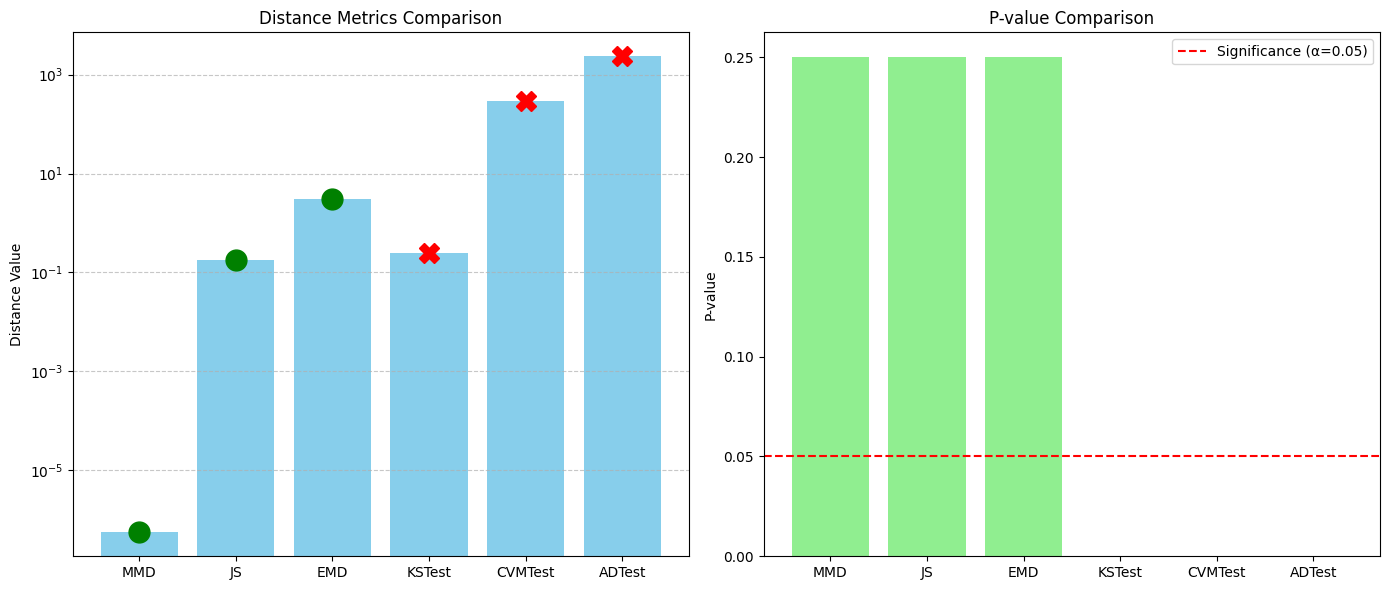

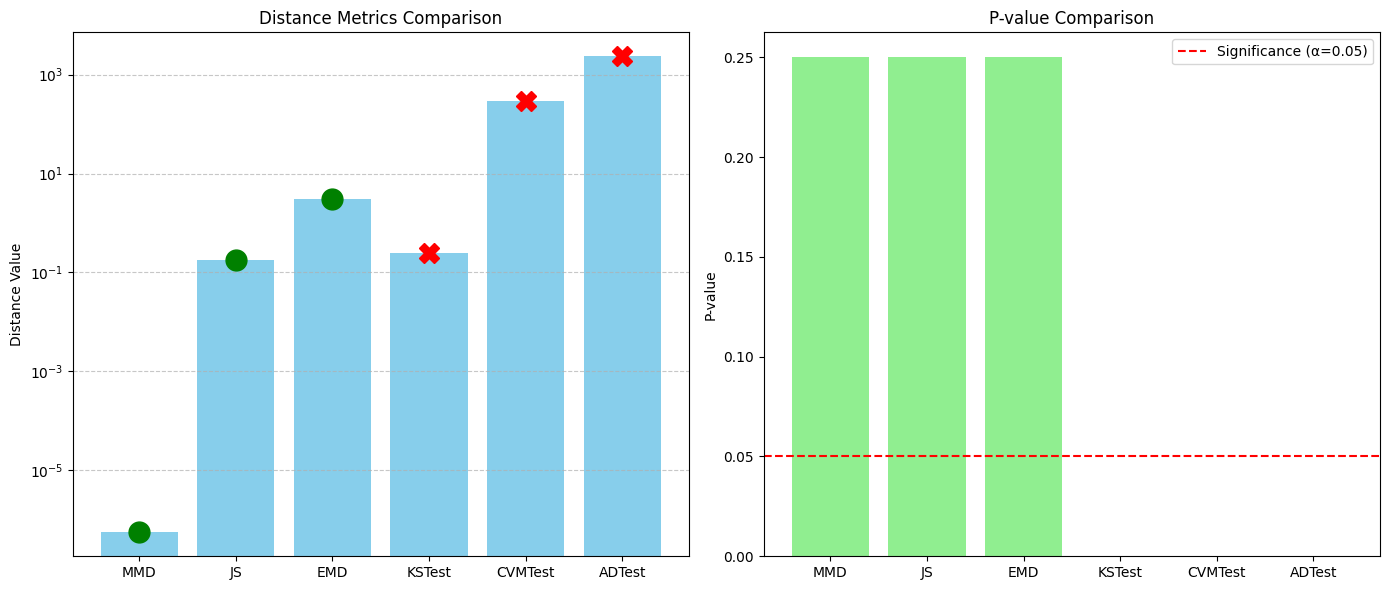

In [146]:
compare_multiple_metrics(results_list, metric_names)